<a href="https://colab.research.google.com/github/krikorantranik/Work/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The idea behind this exercise is to find possible trends in sales data from a pharma company. Time series (data over time) contains an important seasonal component. The goal is to remove the seasonalities and explore what is behind, find the trends and measure the residual against factors that could be related to the sales outcome variable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL
!pip install klib
import klib

Import the dataset

In [2]:
maindataset = pd.read_csv("salesdaily.csv")
maindataset

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday
1,1/3/2014,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday
2,1/4/2014,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday
3,1/5/2014,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday
4,1/6/2014,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,10/4/2019,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday
2102,10/5/2019,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday
2103,10/6/2019,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday
2104,10/7/2019,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday


From Kaggle:

M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives

N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives

N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides

N05B - Psycholeptics drugs, Anxiolytic drugs

N05C - Psycholeptics drugs, Hypnotics and sedatives drugs

R03 - Drugs for obstructive airway diseases

R06 - Antihistamines for systemic use

No missing values found in the dataset.


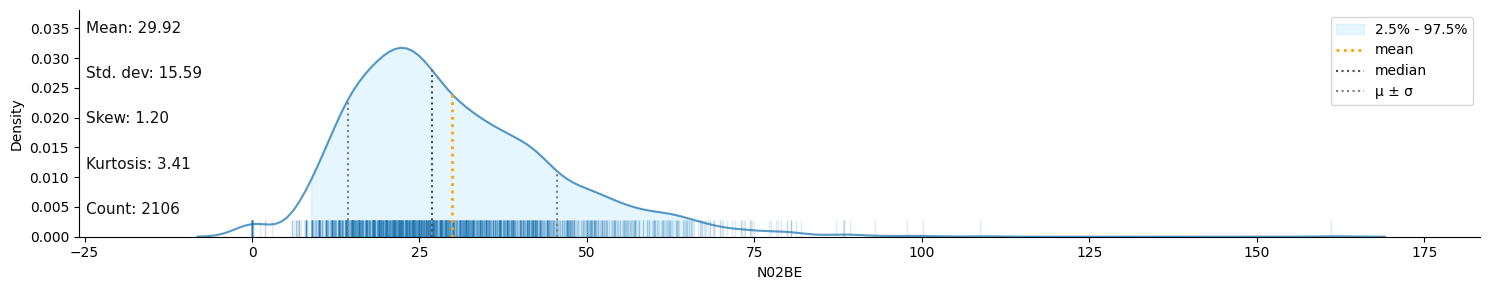

In [4]:
#some exploratory analysis
klib.dist_plot(maindataset['N02BE'])
klib.missingval_plot(maindataset['N02BE'])

I give format to the datetime column and I will start with N02BE, which has more sales data (basically is a group that contains paracetamol and similar analgesics)

In [5]:
maindataset['datum'] = pd.to_datetime(maindataset['datum'], format='%m/%d/%Y')
maindatasetF = maindataset[['datum','N02BE']]
maindatasetF

,datum,N02BE
0,2014-01-02,32.40
1,2014-01-03,50.60
2,2014-01-04,61.85
3,2014-01-05,41.10
4,2014-01-06,21.70
...,...,...
2101,2019-10-04,22.45
2102,2019-10-05,25.40
2103,2019-10-06,34.60
2104,2019-10-07,50.80


The next step is plotting the raw data as is. This is the data we will decompose to extract the seasonal effects

<ipython-input-6-b6a32e96b185>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(maindatasetF, x='datum', y='N02BE', palette="Set1")


<Axes: xlabel='datum', ylabel='N02BE'>

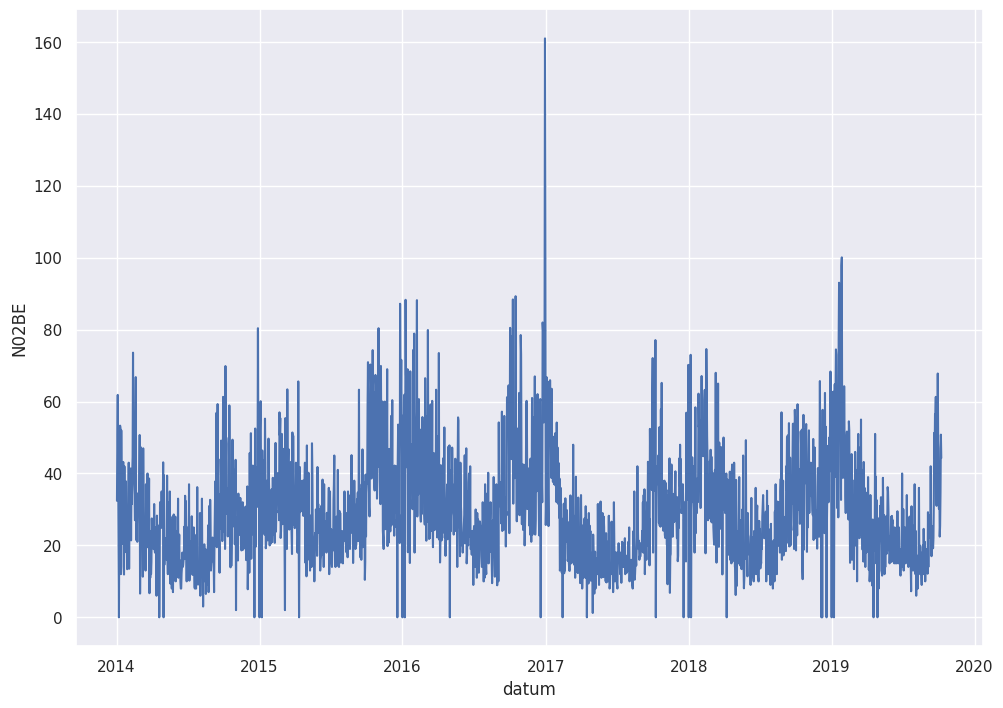

In [6]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(maindatasetF, x='datum', y='N02BE', palette="Set1")

Since we are dealing with time series, the next step is to "complete the series" by filling missing dates with 0 (no sales).

In [7]:
idx = pd.date_range(min(maindatasetF['datum']), max(maindatasetF['datum']), freq='D')
maindatasetF = maindatasetF.sort_values(['datum'])
maindatasetF.index = pd.DatetimeIndex(maindatasetF['datum'])
maindatasetF = maindatasetF.reindex(idx, fill_value=0)
maindatasetF = maindatasetF[['N02BE']]
maindatasetF

,N02BE
2014-01-02,32.40
2014-01-03,50.60
2014-01-04,61.85
2014-01-05,41.10
2014-01-06,21.70
...,...
2019-10-04,22.45
2019-10-05,25.40
2019-10-06,34.60
2019-10-07,50.80


This is the core of the process. After several tries, I could find 4+1 seasonal effects (expressed in the period's parameter of the MSTL function): 1. weekly, monthly (every four weeks), 6 months, and one year.

After running the model I can see that there is another seasonality at 3 years, but unfortunately, this example does not cover long enough to be able to run to model over this time range.

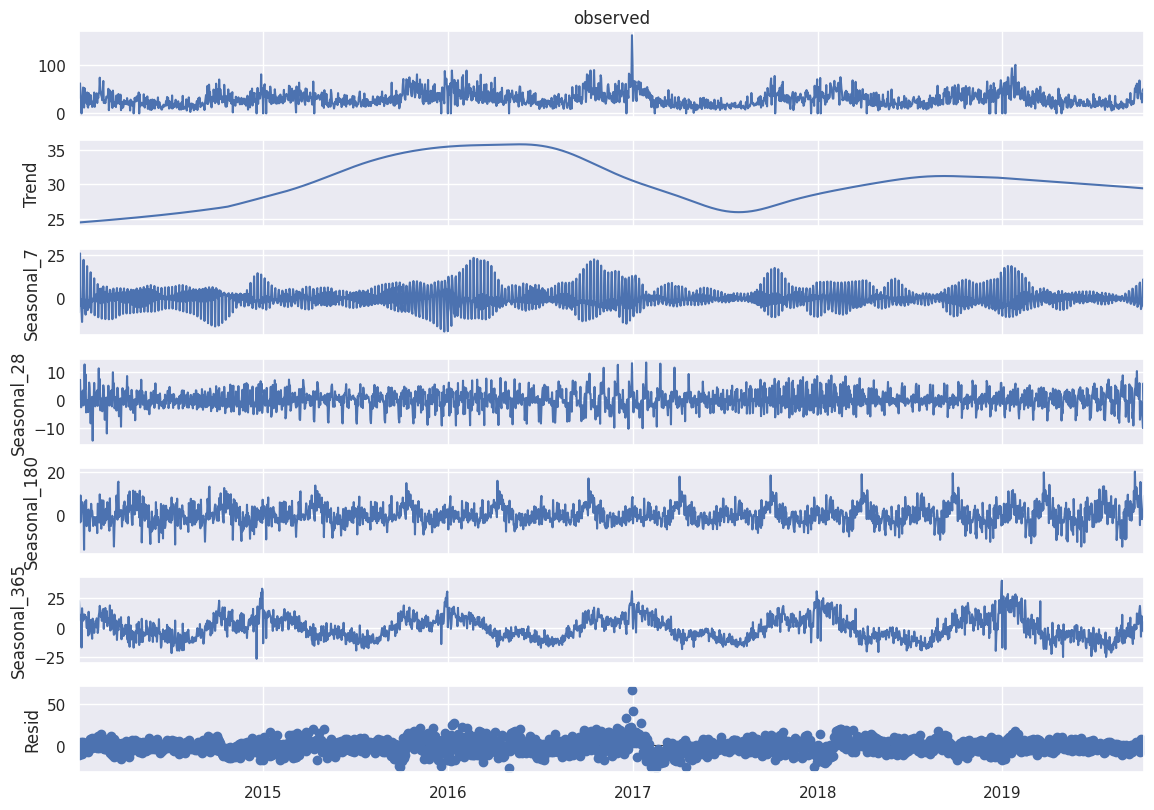

In [8]:
from statsmodels.tsa.seasonal import MSTL
seas = MSTL(maindatasetF, periods=(7, 7*4, 180, 365)).fit()
seas.plot()
plt.tight_layout()
plt.show()

The outcome of this analysis is that the residual can be further analyzed to find trends, or measured against different variables for their impact. These factors and not provided in the example.

<Axes: xlabel='index', ylabel='resid'>

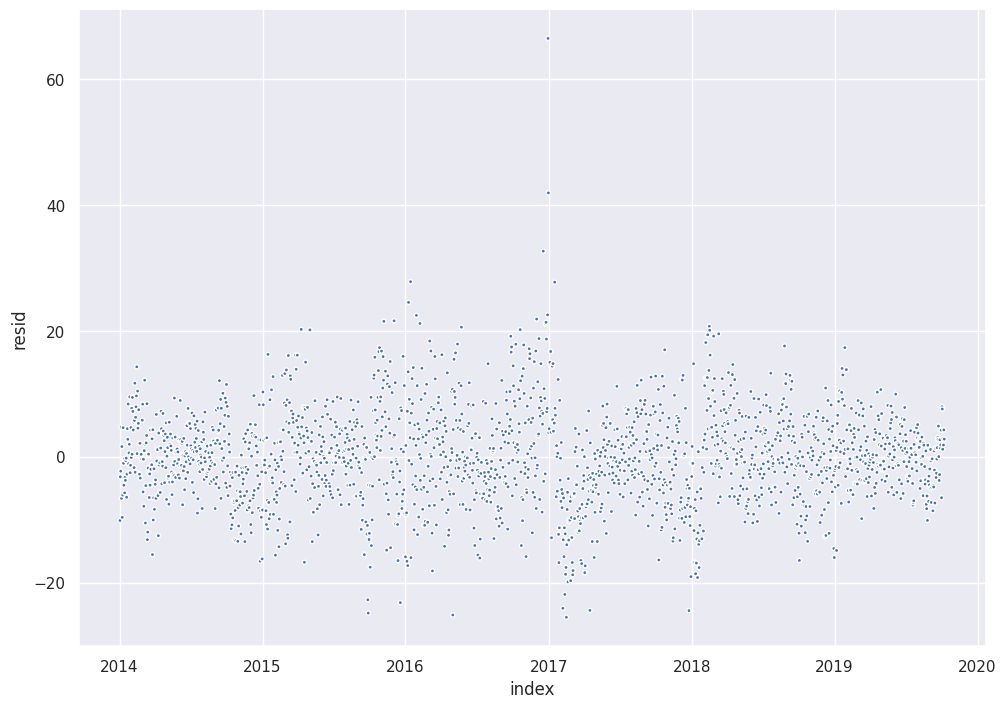

In [9]:
residuals = seas.resid
residuals = pd.DataFrame(residuals).reset_index(drop=False)
sns.scatterplot(residuals, x='index', y='resid', marker='.', linestyle='')